# Tutorial: How to use ExTrack


In this tutorial, I will present the main functions of ExTrack and two example pipelines. 

- First, we will see how to either [simulate tracks](#sim) (2) or [load tracks](#load) (3) to ExTrack format. 
- Then, we will see how to create model parameters and [fit](#fit) them to the tracks (4).
- In addition, the [state-duration histogram](#hist) allows the user to confirm Markovian transitions or to detect non-Markovian transitions (5).
- The [state annotation](#states) function allows to compute the probability for each track to be in any state for each time point (6).
- We will see how to [save](#save) results from ExTrack (7).
- And [visualize](#visualize) tracks and states (8). 
- A [position refinement](#refin) function allows to obtain the most likely position of particles and the corresponding localization uncertainty at every time points (9).
- Finally, the user will be able to run a [first pipeline](#pipeline1) (10) for tracks with previously estimated localization error for each peak, and a [second pipeline](#pipeline2) (11), for tracks with unknown localization error.

In [1]:
import extrack
import numpy as np
from matplotlib import pyplot as plt
import os

multiprocessing is only supported on Linux and MacOS
version: 1.5.5


<a id='sim'></a>

# Simulating tracks

In order to simulate tracks able to come and leave from the field of view, one can use the following function:

### Function extrack.simulate_tracks.sim_FOV

#### Arguments:

- `nb_tracks`: Number of tracks simulated.
- `max_track_len`: Number of steps simulated per track. Defines a maximum track length.
- `min_track_len`: Minimal track length for the track to be considered.
- `LocErr`: 1D array of average localization error (std of the distance between particle and center of detected peak) for each dimension.
- `Ds`: 1D array of the diffusion coefficients for each state.
- `TrMat`: Transition array per step (lines: state at time $n$, cols: states at time n+1).
- `dt`: Time in between frames.
- `nb_dims`: Number of dimensions to output, simulations are always performed in 3D but only the `nb_dims` first spatial dimensions are kept.
- `LocErr_std`: Standard deviation of the distribution of localization errors
- `pBL`: Probability of bleaching (or not detecting the peak) per step.
- `cell_dims`: Dimension limits in x, y and z respectively. x, y dimension limits are useful when tracking membrane proteins in tirf when the particles leave the field of view from the sides of the cells. z dimension is relevant for cytoplasmic proteins which can leave from the z axis. It considers the particles can leave from both ends of each axis: multiply axis limit by 2 to aproximate tracks leaving from one end only.

#### Outputs:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_Bs`: Dictionary descibing the true states of tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_sigmas`: Dictionary describing the localization errors of each peak with the same format as the other outputs, track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = spatial dimensions.

In [2]:
dt = 0.02

# extrack.simulate_tracks.sim_FOV allows to simulate tracks able to leave the field of view

all_tracks, all_Bs, all_sigmas = extrack.simulate_tracks.sim_FOV(nb_tracks=5000,#increase this number to simulate more tracks and gain in precision
                                                                 max_track_len=60,
                                                                 min_track_len = 21,
                                                                 LocErr=np.array([0.02, 0.02, 0.04]), # localization error in x, y and z (even if not used)
                                                                 Ds = np.array([0,0.25]),
                                                                 initial_fractions = np.array([0.6,0.4]),
                                                                 TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                                 dt = dt,
                                                                 nb_dims = 2,
                                                                 LocErr_std = 0, # normalized standard deviation of localization error (coef of variation)
                                                                 pBL = 0.05,
                                                                 cell_dims = [1,None,None])

number of tracks:
21 pos : 130, 22 pos : 113, 23 pos : 109, 24 pos : 101, 25 pos : 75, 26 pos : 75, 27 pos : 86, 28 pos : 60, 29 pos : 61, 30 pos : 53, 31 pos : 30, 32 pos : 38, 33 pos : 30, 34 pos : 45, 35 pos : 36, 36 pos : 42, 37 pos : 28, 38 pos : 30, 39 pos : 35, 40 pos : 22, 41 pos : 24, 42 pos : 34, 43 pos : 27, 44 pos : 27, 45 pos : 31, 46 pos : 19, 47 pos : 12, 48 pos : 10, 49 pos : 20, 50 pos : 18, 51 pos : 14, 52 pos : 6, 53 pos : 8, 54 pos : 5, 55 pos : 14, 56 pos : 8, 57 pos : 11, 58 pos : 6, 59 pos : 3, 60 pos : 69, 


<a id='load'></a>

# Loading data sets


## Load csv files (or other tables)

### function extrack.readers.read_table

The function `extrack.readers.read_table` can be used if files are saved as pickle, csv or other table format with column headers and where each line represents a peak, and each column a property of peaks (at least the x and y positions, the frame number and the track ID). See format:

<img src="http://localhost:8890/tree/Downloads/ExTrack-main/Tutorials/images/img1.png">


#### Arguments:

- `path`: Path to the data in the trackmate xml format.
- `lengths`: Track lengths considered (default value = `np.arange(5,16)`).
- `dist_th`: Maximal distance between consecutive time points (default value = `0.3`).
- `frames_boundaries`: first frame and last frame to consider (default value = `[-np.inf,np.inf]`).
- `fmt`: Format of the document to be red, can be `'csv'` or `'pkl'`. One can also simply specify a separator in case of another table format, e.g. `';'` if colums are separated by ;.
- `colnames`: List of the header names used in the table file to load corresponding to the coordianates, the frame and track ID for each peak. Those must be changed to match your csv format. The first elements (colnames[0], colnames[1] and optionally colnames[2] for 3D tracks) must be the coordinates headers (1 to 3 for 1D to 3D), the penultimate element `colnames[-2]` must be the frame header (numerical values) and the last element `colnames[-1]` must be the track ID of the peak (default value = `['POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID']`). All peaks from the same track must share the same track ID. If multiple tracks share the same track ID `colnames[-1]` must be replaced with a list that allows to obtain unique track IDs. Example: `colnames[-1] = ['TRACK_ID','MOVIE_ID']` 
- `opt_colnames`: List of additional metrics to collect from the file, e.g. `['QUALITY', 'ID']`,(default value = `[]`).
- `remove_no_disp`: If `True`, it removes tracks that show absolutly no displacements as most likely arising from wrong peak detection. (default value = `True`)

#### Outputs:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_frames`: Dictionary descibing the frame numbers of each peak of all tracks with track length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.
- `optional_metrics`: Dictionary describing the optional metrics specified by `opt_colnames` for each peak of all tracks with the same format as the other outputs, track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = optional metrics (same length as the length of the list `opt_colnames`).

In order to import a file from a csv format, the user must specify the necessary column headers of the csv in the argument colnames. It is a list containing the names of the spatial dimensions (the 2 first elements for 2D and 3 first elements for 3D). The last 2 elements of colnames must contain header of columns for: The frame of each peak (must be integer of float) and the Track ID.

In [3]:
path = './example_tracks.csv'



tracks, frames, opt_metrics = extrack.readers.read_table(path, # path of the file to read or list of paths.
                                      lengths = np.arange(5,16), # number of positions per track accepted.
                                      dist_th = 0.3, # Maximum distance allowed for consecutive positions.
                                      frames_boundaries = [0, 10000], # Minimum and maximum frames to consider.
                                      fmt = 'csv', # Format of the document to be red, 'csv' or 'pkl'.
                                      colnames = ['POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID'], 
                                      opt_colnames = ['QUALITY'], # list of additional metrics to collect.
                                      remove_no_disp = True)


Remarkes: - As mentioned, when importing your own data sets, it is important to match `colnames` to the headers/names of the list `[x, y, frame, track_ID]` in this order. One can also load 3D data by specifying a list `[x, y, z, frame, track_ID]`.
WARNING: Sometimes, one column is not enough to identify a track. In those cases colnames[3] can be a list of strings (instead of a simple string). Those strings must correspond to the column names that are required to identify a unique track ID. This can be particularly necessary when multiple movies are contained in the same csv file. In those cases, multiple tracks can have the same track ID. In order to avoid any track ID confusion, a movie ID column must also exist. Therefore, the track ID must be disambiguished by specifying colnames[3] = ['TRACK_ID', 'MOVIE_ID'] for example. An alternative to this is to modify the csv file (ideally via a script) to create unique Track IDs and specify the corresponding column name at colnames[3].


## Load TrackMate xml files

One can also load tracks from actual experiments. If files are saved from trackmate using the trackmate xml output format, load tracks with the function `extrack.readers.read_trackmate_xml`. See format:

<img src="http://localhost:8890/tree/Downloads/ExTrack-main/Tutorials/images/img2.png">


### Function extrack.readers.read_trackmate_xml

#### Arguments:

- `path`: Path to the data in the trackmate xml format.
- `lengths`: Track lengths considered (default value = `np.arange(5,16)`).
- `dist_th`: Maximal distance between consecutive time points (default value = `0.3`).
- `start_frame`: First frame to consider (default value = `0`).
- `remove_no_disp`: If `True`, removes tracks that show absolutly no displacements as most likely arising from wrong peak detection.
- `opt_metrics_names`: Optional data on peak to keep track of (default value = `[]`, can be `['pred_0', 'pred_1']` for instance),
- `opt_metrics_types`: Type of the optional values (default value = `None`, will assume `'float64'` type if `None`).

#### Outputs:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `all_frames`: Dictionary descibing the frame numbers of each peak of all tracks with track length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.
- `optional_metrics`: Dictionary describing the optional metrics specified by `opt_metrics_names` for each peak of all tracks with the same format as the other outputs, track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = optional metrics (same length as the length of the list `opt_metrics_names`).


In [4]:
path = './example_tracks.xml'

tracks, frames, opt_metrics = extrack.readers.read_trackmate_xml(path,
                                       lengths=np.arange(5,10),
                                       dist_th = 0.3,
                                       frames_boundaries = [0, 10000],
                                       remove_no_disp = True, 
                                       opt_metrics_names = [], # Name of the optional metrics to catch and returned by 
                                                               #opt_metrics, opt_metrics will be empty if opt_metrics_names
                                                               #list is empty
                                       opt_metrics_types = None # will assume 'float64' type if none, otherwise specify a
                                                                # list of same length as opt_metrics_names: 
                                                                # e.g. ['float64','float64']
                                       )
print(opt_metrics) # should be empty if opt_metrics_names is empty

{}


<a id='fit'></a>

# Parameter fitting

In order to do the fit we first need to instantiate the parameters of the fit, To do so there is 2 functions:

### Function extrack.tracking.get_params

This function needs to create 4 dictionaries `vary_params`, `estimated_vals`, `min_values`, `max_values` with parameters of the fit as keys and various elements.

#### Arguments:

- `vary_params`: Elements True if the parameter must vary, False otherwise.
- `nb_states`: Number of states assumed by the model.
- `steady_state`: Is assumed at steady state if `True` and not if `False`. if `False` the transition rates and fractions are independent. If `True`, the fractions are determined by the rates.
- `estimated_vals`: Estimated value used to initialize the fit. Good estimation increases speed and decreases chances of wrong local minima.
- `min_values`: Minimum values for each parameter.
- `max_values`: Maximum values for each parameter.

#### Output:

- `params`: lmfit parameters suited to the model.

A second function, `extrack.tracking.generate_params` can also be used. It is easier and quicker to use when there is more than two states. See [generate_params](#generate)  for more details on this function and to see how to perform other types of fit (independent localization error for each spatial dimensions, input localization errors for each peak, etc)


In [ ]:

vary_params = {'LocErr' : True, 'D0' : True, 'D1' : True, 'F0' : True, 'p01' : True, 'p10' : True, 'pBL' : False}
estimated_vals =  {'LocErr' : 0.025, 'D0' : 1e-20, 'D1' : 0.05, 'F0' : 0.45, 'p01' : 0.05, 'p10' : 0.05, 'pBL' : 0.1}
min_values = {'LocErr' : 0.007, 'D0' : 1e-12, 'D1' : 0.00001, 'F0' : 0.001, 'p01' : 0.001, 'p10' : 0.001, 'pBL' : 0.001}
max_values = {'LocErr' : 0.6, 'D0' : 1, 'D1' : 10, 'F0' : 0.999, 'p01' : 1., 'p10' : 1., 'pBL' : 0.99}

params = extrack.tracking.get_params(nb_states = 2,
                    steady_state = False,
                    vary_params = vary_params,
                    estimated_vals = estimated_vals,
                    min_values = min_values,
                    max_values = max_values)


The following function allows the fitting of parameters from ExTrack to the data set:

### Funtion extrack.tracking.param_fitting

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position. This means 15 tracks of 7 time points in 2D will correspond to an array of shape `[15,7,2]`. 
- `dt`: Time in between frames.
- `params`: Parameters previously instanciated.
- `nb_states`: Number of states. `vary_params`, `estimated_vals`, `min_values`, `max_values` should be changed accordingly to describe all states and transitions.
- `nb_substeps`: Number of considered transition steps in between consecutive 2 positions.
- `frame_len`: Number of frames for which the probability is perfectly computed. See method of the paper for more details.
- `verbose`: If 1, print the intermediate values for each iteration of the fit.
- `steady_state`: True if tracks are considered at steady state (fractions independent of time), this is most likely not true as tracks join and leave the FOV.
- `workers`: Number of workers used for the fitting, allows to speed up computation. Do not work from windows at the moment.
- `input_LocErr`: Optional peakwise localization errors used as an input with the same format than `all_tracks`.
- `cell_dims`: Dimension limits (um) (default `[1]`, can also be `[1,2]` for instance in case of two limiting dimensions).
- `threshold`: threshold for the fusion of the sequences of states (default value = 0.2). The threshold is applied to mu the mean position and s the standard deviation of the particle position (see the article for more details). 
- `max_nb_states`: maximum number of sequences of states to consider.
- `method`: Optimization method used by the lmfit package (default = 'BFGS'). Other methods may not work.

#### Outputs:

- model_fit: lmfit model.

#### Usage:

- The number of workers corresponds to the number of cores that can be used. Unfortunatelly multiple cores cannot be used on windows due to how multiprocessing via python works on this OS. Faster computing can be achieved by using linux or Mac OS. An alternative for Windows user is to use WSL. See https://github.com/vanTeeffelenLab/ExTrack/wiki/Muliprocessing-from-Windows for more details on how to use multiprocessing from Windows.

In [5]:

# The following function allows the fitting of parameters from ExTrack to the data set:

model_fit = extrack.tracking.param_fitting(all_tracks = all_tracks,
                                          dt = dt,
                                          params = params,
                                          nb_states = 2,
                                          nb_substeps = 1,
                                          cell_dims = [1],
                                          frame_len = 4,
                                          verbose = 0,
                                          workers = 1,
                                          input_LocErr = None,
                                          steady_state = False,
                                          threshold = 0.2,
                                          max_nb_states=20,
                                          method = 'BFGS')

params = model_fit.params
for param in params:
    print(param, params[param].value)

.....................................................................................................................................................................................................
LocErr 0.020162301711906725
D0 6.49205384698455e-07
D1_minus_D0 0.2467000181791329
D1 0.2467006673845176
F0 0.5100111562613123
F1 0.4899888437386877
p01 0.08849610559496739
p10 0.123722622061744
pBL 0.1


<a id='hist'></a>

# State duration histograms

Next, once we have estimated the parameters of the model, we can produce histograms of time spent in each state using the following function:

### Function `extrack.visualization.visualize_states_durations`

#### arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position. This means 15 tracks of 7 time points in 2D will correspond to an array of shape `[15,7,2]`. 
- `params`: lmfit parameters used for the model. can be extracted from the model using model_fit.params.
- `dt`: Time in between frames.
- `cell_dims`: Dimension limits (um).
- `max_nb_states`: Maximum number of sequences kept (most likely sequences).
- `nb_steps_lim`: Upper limit of the plot in the x axis (number of steps).
- `long_tracks`: If True only selects tracks longer than `nb_steps_lim`.
- `steps`: x axis in seconds if False or in number of steps if False.

#### Outputs:

- Plot of all tracks (preferencially input a single movie).

number of chunks: 55

slop for state 0: -0.09767198852606024
slop for state 1: -0.15308324590923209


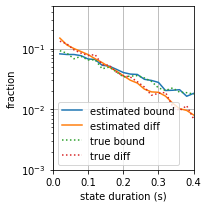

In [6]:
extrack.visualization.visualize_states_durations(all_tracks,
                                                 params = params,
                                                 dt = dt,
                                                 cell_dims = [1],
                                                 nb_states = 2,
                                                 max_nb_states = 200,
                                                 long_tracks = True,
                                                 nb_steps_lim = 20,
                                                 steps = False)

# ground truth histogram (actual labeling from simulations which cannot be assessed for real tracks):

seg_len_hists = extrack.histograms.ground_truth_hist(all_Bs, 2)
plt.plot(np.arange(1,len(seg_len_hists)+1)[:,None]*dt, seg_len_hists/np.sum(seg_len_hists,0), ':')
plt.legend(['estimated bound','estimated diff','true bound','true diff'])

# computation of the slops of the histograms:

print('slop for state 0:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,0], 1)[0])
print('slop for state 1:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,1], 1)[0])

# we can notice the slops are not equal to the rates due to the fraction of tracks leaving the field of view.

<a id='generate'></a>

We saw the function `extrack.tracking.get_params` to produce parameters. One can also use the function `extrack.tracking.generate_params`.

### Function `extrack.tracking.generate_params`

Arguments:

- `nb_states`: Number of states of the model.
- `LocErr_type`: Type of localization errors which can be specified, unique/multiple localization error parameters, input localization error for each peak based on peaks, etc. See below for more information. 
- `nb_dims`: Number of spatial dimensions, only matters if `LocErr_type = 2`, which stands for independent localization error parameters for each dimension.
- `LocErr_bounds`: List of minimal and maximal values allowed for localization error parameters. e.g. `[0.005, 0.1]`., The initial guess on LocErr will be the geometric mean of the boundaries if `estimated_LocErr = None`.
- `D_max`: Maximum diffusion coefficient allowed.
- `Fractions_bounds`: List of minimum and maximum values for initial fractions.
- `estimated_LocErr`: One can specify a list of initial guesses for localization error for each dimension. The list must contain 1 element if LocErr_type = 1, nb_dims elements if LocErr_type = 2 (for each dimension) or 2 elements if LocErr_type = 3 (the first element for x,y axes and the second for z axis).
- `estimated_Ds`: List of estimated diffusion coefficients (nb_states elements), D will be arbitrary interspaced from `0` to `D_max` if `None`, otherwise input 1D array/list of Ds for each state from state `0` to `nb_states - 1`.
- `estimated_Fs`: List of estimated initial fractions (nb_states elements). Fractions will be initialized as equal if `None` (1/nb_states), otherwise input 1D array/list of fractions for each state from state `0` to `nb_states - 1`.
- `estimated_transition_rates`: Initial guess of the values for transition rate per step. Can be a float (from 0 to 1), in this case all rates will be initialized with the same float value. Can also be a 1D array or list of transition rates from state `i` to `j` varying the `i` then the `j`, for instance `[k01, k02, k10, k12, k20, k21]` in case of a 3-state model. The number of elements must be `nb_states * (nb_states -1)`.
- `slope_offsets_estimates`: If LocErr_type = 4, list of Initial guesses for the slope and offset where the peak-wise proxi for localization error input_LocErr is linked to the actual localization error such that: localization error = slope * `input_LocErr` + offset.
)

Output:

- `params`: lmfit parameters suited to the model.

`LocErr_type` allows to specify the model assumptions.


### The argument `LocErr_type`:

The argument `LocErr_type` allows to create a list of parameters that is most suited to the experiments: If `LocErr_type = None` Localization error will not be considered as a parameter and thus won't be fitted. In this specific case, the user will have to use `input_LocErr` in the fitting function to inform the model about localization error for each peak (See below). 

- `LocErr_type = 1`: For a single localization error parameter, all spatial dimensions will use the same localization error.
- `LocErr_type = 2`: For a localization error parameter for each dimension. Localization error parameter for dim $i$ will be `'LocErr'+str(i)`.
- `LocErr_type = 3`: For a shared localization error for x and y dims (the 2 first dimensions) and another for z dimension. The z dimension has to be the 3rd in the input tracks.
- `LocErr_type = 4`: Can be used when the user has a measurement of the peak quality which is not exactly the localization error. It will draw an affine relationship between localization error according to ExTrack and the peak-wise input specified with `input_LocErr` (an estimate of localization error/quality of peak/signal to noise ratio, etc).
- `LocErr_type = None`: For no localization error fits, localization error is then directly assumed from a prior peak-wise estimate of localization error specified in input_LocErr.

See https://github.com/vanTeeffelenLab/ExTrack/blob/main/Tutorials/Fitting_methods.ipynb for a tutorial for the different model assumptions. 

In [8]:
# Here we use this function to set param values.

params = extrack.tracking.generate_params(nb_states = 2,
                        LocErr_type = 1,
                        nb_dims = 2, # Only matters if LocErr_type == 2.
                        LocErr_bounds = [0.005, 0.1], #The initial guess on LocErr will be the geometric mean of the boundaries.
                        D_max = 10, # Maximal diffusion coefficient allowed.
                        Fractions_bounds = [0.001, 0.99], # Min and max of the fractions.
                        estimated_LocErr = [0.02], # Estimated localization error.
                        estimated_Ds = [0, 0.25], # D will be arbitrary spaced from 0 to D_max if None,
                        estimated_Fs = [0.5,0.5], # fractions will be equal if None,
                        estimated_transition_rates = 0.1, # Transition rates per step.
                                          
                        )

# Can be addapted for more states by specifying all the relevant parameters.

# parameters can be fixed using the following command (here for 'D0' but also works with any parameter):
params['D0'].vary = False

<a id='states'></a>

# Probabilistic state annotation

ExTrack can also perform state predictions using the following function:

## Performing state predictions

### Function `extrack.tracking.predict_Bs`

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position. This means that 15 tracks of 7 time points in 2D will correspond to an array of shape `[15,7,2]`.
- `params`: lmfit parameters used for the model.
- `dt`: Time in between frames.
- `cell_dims`: Dimension limits.
- `nb_states`: Number of states.`vary_params`, `estimated_vals`, `min_values`, `max_values` should be changed accordingly to describe all states and transitions.
- `frame_len`: Number of frames for which the probability is accurately computed. See the window length in the method section of the [ExTrack paper](https://doi.org/10.1101/2022.07.13.499913) for more details.

#### Outputs:

- `pred_Bs`: Dictionary describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.

In [9]:

# Simulation of fiewer tracks to plot them and their annotation inferred by ExTrack :

all_tracks, all_Bs, all_sigmas = extrack.simulate_tracks.sim_FOV(nb_tracks=300,
                                                     max_track_len=60,
                                                     min_track_len = 5,
                                                     LocErr=0.02,
                                                     Ds = np.array([0,0.5]),
                                                     initial_fractions = np.array([0.6,0.4]),
                                                     TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                     dt = dt,
                                                     pBL = 0.1,
                                                     LocErr_std = 0.1, # normalized standard deviation of localization error
                                                     cell_dims = [1,] # dimension limits in x, y and z respectively
                                                     )

# Performs the states probability predictions based on the most likely parameters :

pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt = dt,
                                      params = params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=8,
                                      workers = 1,
                                      input_LocErr = all_sigmas)


number of tracks:
5 pos : 41, 6 pos : 28, 7 pos : 29, 8 pos : 19, 9 pos : 14, 10 pos : 12, 11 pos : 17, 12 pos : 13, 13 pos : 10, 14 pos : 9, 15 pos : 6, 16 pos : 5, 17 pos : 7, 18 pos : 7, 19 pos : 10, 20 pos : 1, 21 pos : 1, 22 pos : 6, 24 pos : 1, 25 pos : 1, 26 pos : 1, 27 pos : 5, 28 pos : 1, 29 pos : 1, 30 pos : 1, 31 pos : 1, 32 pos : 1, 33 pos : 1, 34 pos : 1, 35 pos : 1, 36 pos : 1, 42 pos : 1, 51 pos : 1, 


<a id='save'></a>

# Saving results

## Converting ExTrack format to pandas dataframe

In order to turn outputs from extrack to a more classical data frame format the user can use the following function:

### Function `extrack.exporters.extrack_2_pandas`

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `pred_Bs`: Dictionary describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- `frames`: Dictionary describing the frame of each position of each track with keys track length (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if none.
- `opt_metrics`: Dictionary of dictionaries for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. `{'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}`.

#### Outputs:

- `DATA`: pandas dataframe containing the necessary informations for each track.

In [11]:

DATA = extrack.exporters.extrack_2_pandas(all_tracks, pred_Bs, frames = None, opt_metrics = {})


Then, tracks can be saved to a xml file with TrackMate format for compatibility with TrackMate or as a CSV file:

## Saving tracks with predictions to TrackMate xml format

To do so one can use the following function:

### Function `extrack.exporters.save_extrack_2_xml`

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `pred_Bs`: Dictionary describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- `params`: lmfit parameters.
- `path`: Path + name of the saved file.
- `dt`: Time in between frames.
- `all_frames`: Dictionary describing the frame of each position of each track with keys track length (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if `all_frames = None`.
- `opt_metrics`: Dictionary of dictionaries for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. `{'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}`. It can be an empty dictonnary.

In [12]:
# save as xml file used for trackmate :

save_path = './saved_tracks.xml' 
extrack.exporters.save_extrack_2_xml(all_tracks,
                                     pred_Bs,
                                     params = params,
                                     path = save_path,
                                     dt = dt,
                                     all_frames = None,
                                     opt_metrics = {})

# Here we don't have optional metrics to save but see below for an example with optional metrics.


## Saving tracks with predictions to csv format
To do so, once we have converted variables at the ExTrack format, we can simply use the method to_csv from pandas dataframes:


In [13]:
# save as csv file:
save_path = './saved_tracks.csv' 
DATA.to_csv(save_path)

<a id='visualize'></a>

# Visualizing tracks

## Visualizing state perdictions

In order to show all tracks on top of each other, one can use the following function:

### Function extrack.visualization.visualize_tracks

#### Arguments:

- `DATA`: dataframe outputed by extrack.exporters.extrack_2_pandas.
- `track_length_range`: Range of tracks plotted. Plotting too many tracks may make it crash.
- `figsize`: Size of the figure plotted.

.............

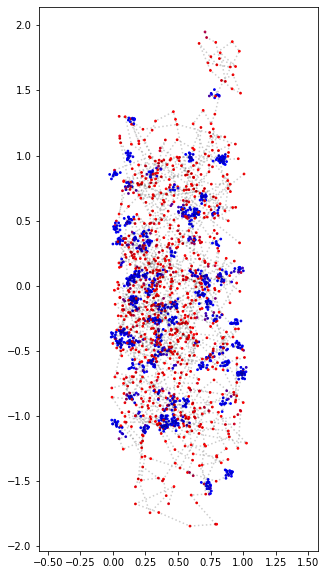

In [14]:
# show all tracks:

extrack.visualization.visualize_tracks(DATA,
                                       track_length_range = [10,np.inf],
                                       figsize = (5,10))

In order to see the longest tracks in more details, one can use the following function:

### Function extrack.visualization.plot_tracks

#### Arguments:

- `DATA`: dataframe outputed by extrack.exporters.extrack_2_pandas.
- `max_track_length`: Maximum track length to show, it will plot the longest tracks respecting this criteria.
- `nb_subplots`: Number of lines and columns of subplots.
- `figsize`: Size of the figure plotted.

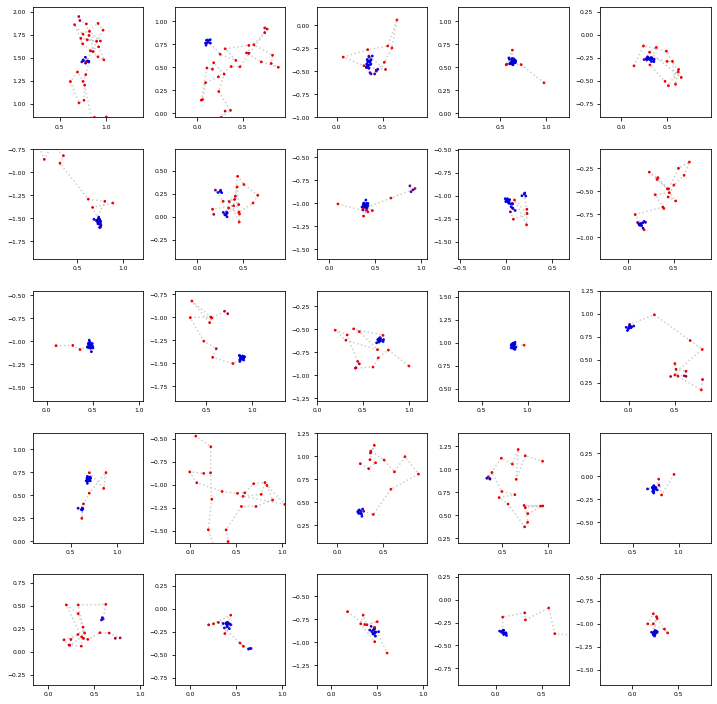

In [15]:
# show the longest tracks in more details :

extrack.visualization.plot_tracks(DATA,
                                  max_track_length = 50,
                                  nb_subplots = [5,5],
                                  figsize = (10,10), 
                                  lim = 0.6)

<a id='refin'></a>

# Position refinement module

Position refinement module allows to refine track position by integration of the signal over consecutive positions.

## Refined Position and standard deviation

We can noticeably obtain the most likely position for each time point of each track using the function `position_refinement`:

### Function extrack.refined_localization.position_refinement

#### Arguments:

- `all_tracks`: Dictionary describing the tracks with track length as keys (number of time positions, e.g. `'23'`) of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- `LocErr`: float number for localization error.
- `ds`: 1D array containing diffusion lengths for each state.
- `Fs`: 1D array containing diffusion lengths for each state.
- `TrMat`: 2D array transition rates. with `TrMat[i,j]` = transition probability from state i to j and `TrMat[i,i] = 1 - sum TrMat[i,j]` for all j.
- `frame_len`: window length to be used from each side of the position to be refined.

#### Outputs:

- `all_mus`: Dictionary describing the most likely positions with length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.
- `all_refined_sigmas`: Dictionary describing the refined localization errors with length as keys (number of time positions, e.g. `'23'`) of 2D arrays: dim 0 = track, dim 1 = time position.

NB: This function is not considering specified localization error but will do soon.

number of tracks:
50 pos : 46, 


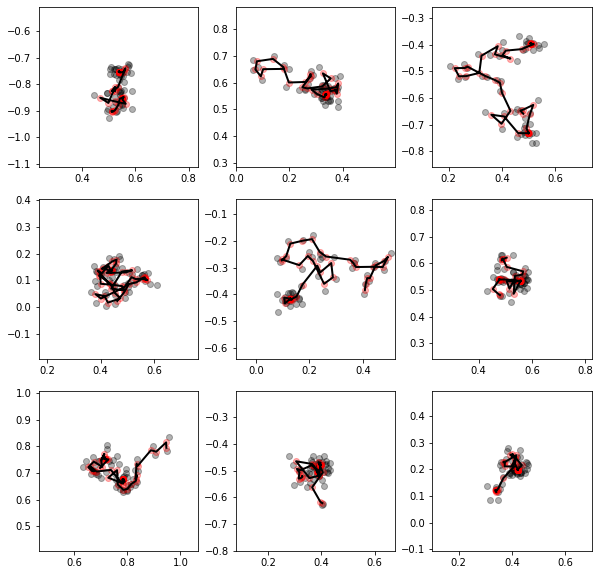

In [16]:

Ds = np.array([0,0.04])
TrMat = np.array([[0.9,0.1],[0.1,0.9]])
Fs = np.array([0.6,0.4])
LocErr = 0.02
dt = 0.02
ds = (2*Ds*dt)**0.5 # d* of 3
track_len = 50

all_tracks, all_Bs, all_sigmas = extrack.simulate_tracks.sim_FOV(nb_tracks=60,
                                                     max_track_len=track_len,
                                                     min_track_len = track_len,
                                                     LocErr=LocErr,
                                                     Ds = Ds,
                                                     initial_fractions = Fs,
                                                     TrMat = TrMat,
                                                     dt = dt,
                                                     pBL = 0.001,
                                                     cell_dims = [1,]) # dimension limits in x, y and z respectively.

all_mus, all_refined_sigmas = extrack.refined_localization.position_refinement(all_tracks, LocErr, ds, Fs, TrMat, frame_len = 7)

plt.figure(figsize = (10,10))

lim = 0.3
for k in range(1, 10):
    plt.subplot(3,3,k)
    track = all_tracks[str(track_len)][k]
    refined_pos = all_mus[str(track_len)][k]
    plt.scatter(track[:,0], track[:,1], c = 'k', alpha = 0.3)
    plt.plot(refined_pos[:,0], refined_pos[:,1], 'k', linewidth = 2)
    plt.scatter(refined_pos[:,0], refined_pos[:,1], c = 'r', alpha = 0.3)
    plt.xlim([np.mean(track[:,0]) - lim, np.mean(track[:,0]) + lim])
    plt.ylim([np.mean(track[:,1]) - lim, np.mean(track[:,1]) + lim])
    plt.gca().set_aspect('equal', adjustable='box')


The gray dots represent the track positions (with noise) and the red dots represent the most likely positions. 

<a id='pipeline1'></a>

# Overview of a full pipeline

Now that we have seen how each module is working, we will run a complete analysis pipeline and save all results in a xml or csv file. This pipeline is realised for tracks which possess peak-wise localization error estimates from the peak detection step. If you want to addapt this pipline to your own data sets and if you don't have peak-wise localization error estimates, there is a pipeline for it at the last cell of this tutorial. For more insights into the different model assumptions allowed by ExTrack see the other tutorial https://github.com/vanTeeffelenLab/ExTrack/blob/main/Tutorials/Fitting_methods.ipynb or the corresponding wiki page https://github.com/vanTeeffelenLab/ExTrack/wiki/Instanciating-model-parameters.

## Loading tracks

In [17]:
# here data have localization error informations for x and y dimensions LocErrs0 and LocErrs1 (resp.):

dt = 0.02

path =  './tracks.xml' # for xml format

all_tracks, all_frames, opt_metrics = extrack.readers.read_trackmate_xml(path,
                                       lengths=np.arange(5,50),
                                       dist_th = 1,
                                       frames_boundaries = [0, 10000],
                                       remove_no_disp = True, 
                                       opt_metrics_names = ['LocErrs0', 'LocErrs1'], # e.g. ['pred_0', 'pred_1'],
                                       opt_metrics_types = None # will assume 'float64' type if none, otherwise specify a list of same length as opt_metrics_names: e.g. ['float64','float64']
                                       )

# or for a csv file:

path = './tracks.csv'
# headers of the csv above are: X,Y,frame,track_ID,pred_0,pred_1,LocErrs0,LocErrs1.
# We then need to change the argument colnames accordingly.

all_tracks, frames, opt_metrics = extrack.readers.read_table(path, # path of the file to read or list of paths.
                                      lengths = np.arange(5,50), # number of positions per track accepted (take the first position if longer than max.
                                      dist_th = 0.3, # maximum distance allowed for consecutive positions. 
                                      frames_boundaries = [0, 10000], # minimum and maximum frames allowed.
                                      fmt = 'csv', # format of the document to be red, 'csv' or 'pkl', one can also just specify a separator e.g. ' '. 
                                      colnames = ['X', 'Y', 'frame', 'track_ID'], 
                                      opt_colnames = ['LocErrs0', 'LocErrs1'], # list of additional metrics to collect e.g. ['QUALITY', 'TRACK_ID'].
                                      remove_no_disp = True)

print('LocErrs0 shape for tracks of 10 time points is:', opt_metrics['LocErrs0']['10'].shape, 'We need input_LocErr with format (66, 10, 2)')

# We have to turn LocErrs0 and LocErrs1 to the correct shape for input_LocErr, which is (nb tracks, nb time points, nb dims=2).

input_LocErr = {}
for l in all_tracks.keys():
    input_LocErr[l] = np.concatenate((opt_metrics['LocErrs0'][l][:,:,None], opt_metrics['LocErrs1'][l][:,:,None]),axis = 2) # concatenate on the axis 2 which represents the spatial dims


LocErrs0 shape for tracks of 10 time points is: (66, 10) We need input_LocErr with format (66, 10, 2)


## Fitting

In [18]:

params = extrack.tracking.generate_params(nb_states = 2,
                        LocErr_type = None,
                        nb_dims = 2, # only matters if LocErr_type == 2,
                        LocErr_bounds = [0.005, 0.1], # the initial guess on LocErr will be the geometric mean of the boundaries
                        D_max = 10, # maximal diffusion coefficient allowed
                        Fractions_bounds = [0.001, 0.99]
                        )

model_fit = extrack.tracking.param_fitting(all_tracks = all_tracks,
                                          dt = dt,
                                          params = params,
                                          nb_states = 2,
                                          nb_substeps = 1,
                                          cell_dims = [1],
                                          frame_len = 4,
                                          verbose = 0,
                                          workers = 1, # keep to 1 on mac or windows or it won't work.
                                          steady_state = False,
                                          input_LocErr = input_LocErr
                                          )

params = model_fit.params
for param in params:
    print(param, params[param].value)

.........................................................................................................................................................................................................................................................................................
D0 2.0463280231419745e-05
D1 0.4679739982009756
F0 0.44956395927862547
F1 0.5504360407213745
p01 0.10252191889605414
p10 0.09958018008121823
pBL 0.08302645315421513


## Probabilistic state annotation

In [19]:

pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt = dt,
                                      params = params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=8,
                                      workers = 1,
                                      input_LocErr = input_LocErr)


## Position refinement

In [20]:
Ds = np.array([0,0.05])
TrMat = np.array([[0.9,0.1],[0.1,0.9]])
Fs = np.array([0.6,0.4])
LocErr = 0.02
ds = (2*Ds*dt)**0.5 # d* of 3.
track_len = 50

all_mus, all_refined_sigmas = extrack.refined_localization.position_refinement(all_tracks, LocErr, ds, Fs, TrMat, frame_len = 7)

refined_pos0 = {}
refined_pos1 = {}
refined_LocErrs = {}
for l in all_tracks.keys():
    refined_pos0[l] = all_mus[l][:,:,0]
    refined_pos1[l] = all_mus[l][:,:,1]
    refined_LocErrs[l] = all_refined_sigmas[l][:,:]


## Saving as TrackMate xml file 

In [21]:

save_path = './saved_tracks2.xml'

extrack.exporters.save_extrack_2_xml(all_tracks,
                                     pred_Bs,
                                     params = params,
                                     path = save_path,
                                     dt = dt,
                                     all_frames = None,
                                     opt_metrics = {'LocErrs0': opt_metrics['LocErrs0'],
                                                    'LocErrs1': opt_metrics['LocErrs1'], 
                                                    'refined_x_pos': refined_pos0,
                                                    'refined_y_pos': refined_pos1,
                                                    'refined_LocErrs': refined_LocErrs}
                                     )


## Saving as csv file 

In [22]:

# first we convert our data to a pandas dataframe:
DATA = extrack.exporters.extrack_2_pandas(all_tracks,
                                          pred_Bs,
                                          frames = None,
                                          opt_metrics = {'LocErrs0': opt_metrics['LocErrs0'],
                                                         'LocErrs1': opt_metrics['LocErrs1'], 
                                                         'refined_x_pos': refined_pos0,
                                                         'refined_y_pos': refined_pos1,
                                                         'refined_LocErrs': refined_LocErrs}
                                          )
print(DATA)

save_path = './saved_tracks2.csv'

DATA.to_csv(save_path)


             X         Y  frame  track_ID    pred_0    pred_1  LocErrs0  \
0     0.234391 -0.089205      0         0  0.883780  0.116220  0.021328   
1     0.187617 -0.070469      1         0  0.986221  0.013779  0.021759   
2     0.233839 -0.056534      2         0  0.986458  0.013542  0.020291   
3     0.156714 -0.055737      3         0  0.951223  0.048777  0.022241   
4     0.185732 -0.027498      4         0  0.895528  0.104472  0.018353   
...        ...       ...    ...       ...       ...       ...       ...   
9805  0.440053 -1.153825     44       890  0.999917  0.000083  0.022228   
9806  0.431732 -1.142476     45       890  0.999906  0.000094  0.022538   
9807  0.450574 -1.144497     46       890  0.999826  0.000174  0.018374   
9808  0.429974 -1.110610     47       890  0.998833  0.001167  0.016955   
9809  0.430944 -1.141991     48       890  0.994527  0.005473  0.016759   

      LocErrs1  refined_x_pos  refined_y_pos  refined_LocErrs  
0     0.019993       0.218766      

<a id='pipeline2'></a>

# Full pipeline considering localization error as a fitted parameter

Here, contrary to the full pipeline presented above, we don't have prior knowledge on localization error based on peaks so we assum a unique localization error that can be fitted by specifying `LocErr_type = 1` in the function `extrack.tracking.generate_params`. For different model assumptions see the other tutorial https://github.com/vanTeeffelenLab/ExTrack/blob/main/Tutorials/Fitting_methods.ipynb/Fitting_methods.ipynb.

.........................................................................................................................................................................................................................................................................................................................................................
D0 2.8555503361338275e-05
D1 0.4684362208443188
LocErr 0.020117265326441668
F0 0.4482631739188528
F1 0.5517368260811473
p01 0.1019865727692332
p10 0.09951455136856181
pBL 0.0829509724151251
             X         Y  frame  track_ID    pred_0    pred_1  refined_x_pos  \
0     0.234391 -0.089205      0         0  0.878804  0.121196       0.206881   
1     0.187617 -0.070469      1         0  0.983718  0.016282       0.199627   
2     0.233839 -0.056534      2         0  0.981945  0.018055       0.200019   
3     0.156714 -0.055737      3         0  0.933636  0.066364       0.196989   
4     0.185732 -0.027498      4         0  0.888516  0.111484   

array([[1.01610280e+02, 1.43397354e+02],
       [9.33757192e+01, 1.20668869e+02],
       [8.75494935e+01, 9.62740716e+01],
       [7.10216886e+01, 7.96035422e+01],
       [6.39190175e+01, 6.32981316e+01],
       [4.23650520e+01, 5.01662568e+01],
       [2.89829599e+01, 3.61879712e+01],
       [2.44202650e+01, 2.48263011e+01],
       [2.70563731e+01, 2.10802420e+01],
       [1.47319979e+01, 1.30271510e+01],
       [2.44513391e+01, 1.02056590e+01],
       [1.76673539e+01, 6.89045492e+00],
       [9.60159293e+00, 5.95837438e+00],
       [7.60426644e+00, 4.58835417e+00],
       [6.57308859e+00, 2.77635401e+00],
       [5.95594106e+00, 2.45247408e+00],
       [3.77411204e+00, 1.33719605e+00],
       [6.07624740e-01, 9.46747281e-01],
       [2.31694737e+00, 6.90868135e-01],
       [1.32119774e+00, 1.13299581e+00],
       [4.42315089e+00, 2.87142372e-01],
       [8.65643979e-01, 1.64183889e-01],
       [2.04896291e+00, 3.64894906e-01],
       [5.51690022e-01, 2.16847053e-01],
       [4.199230

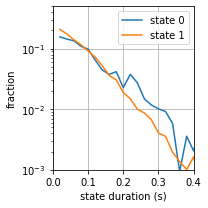

In [24]:
# Here we import tracks from a csv file where each row corresponds to a peak with a
# column for x position of the peak, a colum for y position, one for the frame of 
# the peak and another for the track ID of the peak, the columns do not have to be
# in a specific order but the column names (headers) need to be specified.

path = './tracks.csv'

# headers of the csv above are: X,Y,frame,track_ID,pred_0,pred_1,LocErrs0,LocErrs1.
# If the user have headers with other names, they can specify the header names in 
# the argument colnames which is a list with first element the x position, second
# element the x position, third element, the frame of the peak and fourth element
# the track ID of the peak.

dt = 0.02 # set time in between frames in second.

all_tracks, frames, opt_metrics = extrack.readers.read_table(path, # path of the file to read or list of paths.
                                      lengths = np.arange(5,50), # number of positions per track accepted (takes the first positions if a track is longer than the maximum value of lengths.
                                      dist_th = 0.3, # maximum distance allowed for consecutive positions. 
                                      frames_boundaries = [0, 10000], # minimum and maximum frames allowed.
                                      fmt = 'csv', # format of the document to be red, 'csv' or 'pkl', one can also just specify a separator e.g. ' '. 
                                      colnames = ['X', 'Y', 'frame', 'track_ID'], 
                                      opt_colnames = [], # list of additional metrics to collect e.g. ['QUALITY', 'TRACK_ID'].
                                      remove_no_disp = True)

params = extrack.tracking.generate_params(nb_states = 2,
                    LocErr_type = 1, # set to 1 to fit a unique localization error for all peaks.
                    nb_dims = 3, # only matters if LocErr_type == 2,
                    LocErr_bounds = [0.005, 0.1], # the initial guess on LocErr will be the geometric mean of the boundaries
                    D_max = 10, # maximal diffusion coefficient allowed
                    Fractions_bounds = [0.001, 0.99],
                    estimated_LocErr = None,
                    estimated_Ds = None, # D will be arbitrary spaced from 0 to D_max if None, otherwise input 1D array/list of Ds for each state from state 0 to nb_states - 1.
                    estimated_Fs = None, # fractions will be equal if None, otherwise input 1D array/list of fractions for each state from state 0 to nb_states - 1.
                    estimated_transition_rates = 0.1, # transition rate per step. [0.1,0.05,0.03,0.07,0.2,0.2]
                    slope_offsets_estimates = None # need to specify the list [slop, offset] if LocErr_type = 4.
                    )

# Parameter fitting:
model_fit = extrack.tracking.param_fitting(all_tracks = all_tracks,
                                          dt = dt,
                                          params = params,
                                          nb_states = 2,
                                          nb_substeps = 1,
                                          cell_dims = [1],
                                          frame_len = 4,
                                          verbose = 0,
                                          workers = 1, # increase the number of CPU workers for faster computing, do not work on windows or mac (keep to 1).
                                          steady_state = False,
                                          input_LocErr = None
                                          )

params = model_fit.params
for param in params:
    print(param, params[param].value)

# State annotation:
pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt = dt,
                                      params = params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=8,
                                      workers = 1,
                                      input_LocErr = None)

# Position refinement
LocErr, ds, Fs, TrMat, pBL = extrack.tracking.extract_params(params, 
                                                             dt,
                                                             nb_states = 2,
                                                             nb_substeps = 1,
                                                             input_LocErr = None,
                                                             Matrix_type = 1)


LocErr = LocErr[0][0,0,0]
all_mus, all_refined_sigmas = extrack.refined_localization.position_refinement(all_tracks,
                                                                               LocErr,
                                                                               ds,
                                                                               Fs,
                                                                               TrMat,
                                                                               frame_len = 7)

refined_pos0 = {}
refined_pos1 = {}
refined_LocErrs = {}
for l in all_tracks.keys():
    refined_pos0[l] = all_mus[l][:,:,0]
    refined_pos1[l] = all_mus[l][:,:,1]
    refined_LocErrs[l] = all_refined_sigmas[l][:,:] # this corresponds to a shared sigma for x and y axes.

# Saving as csv file:
DATA = extrack.exporters.extrack_2_pandas(all_tracks,
                                          pred_Bs,
                                          frames = None,
                                          opt_metrics = {'refined_x_pos': refined_pos0,
                                                         'refined_y_pos': refined_pos1,
                                                         'refined_LocErrs': refined_LocErrs}
                                          )
print(DATA)

save_path = './saved_tracks2.csv'

DATA.to_csv(save_path)

# plotting state histograms:
extrack.visualization.visualize_states_durations(all_tracks,
                                                 params = params,
                                                 dt = dt,
                                                 cell_dims = [1],
                                                 nb_states = 2,
                                                 max_nb_states = 200,
                                                 long_tracks = False,
                                                 nb_steps_lim = 20,
                                                 steps = False)
